In [1]:
import numpy as np
import jax.numpy as jnp

import fdringdown as rd
import astropy.constants as const

import matplotlib.pyplot as plt
import rcparams
plt.rcParams.update(rcparams.params)

import matplotlib.colors
from matplotlib.lines import Line2D
from matplotlib.collections import LineCollection

from cmcrameri import cm

from ripple.waveforms import IMRPhenomD
from ripple import ms_to_Mc_eta

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
G, c, M_sun, au = const.G.value, const.c.value, const.M_sun.value, const.au.value

# G/c**3 (s/kg)
conversion = G/c**3

In [3]:
def h(M, f, r):
    return ((G*M)**(5/3)*f**(2/3))/(c**4*r)

In [4]:
h(100*M_sun, 100, 650*1e6*3.086e16)

9.891465333852547e-22

In [5]:
h(72*M_sun, 100, 440*1e6*3.086e16)

8.4516623981666345e-22

In [6]:
def time_to_merger(f, Mc):
    return (5/(8*np.pi)**(8/3))*(conversion*Mc)**(-5/3)*f**(-8/3)

def gw_frequency(time_to_merger, Mc):
    return (((8*np.pi)**(8/3)/5)*(conversion*Mc)**(5/3)*time_to_merger)**(-3/8)

def gw_frequency_from_a(a, M):
    return 2*np.sqrt((G*M)/(4*np.pi**2*a**3))

In [7]:
# Create the event class
event = rd.GWevent('GW150914')

Loading file H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5
Loading file L-L1_GWOSC_4KHZ_R1-1126257415-4096.hdf5


In [8]:
# Get the event GPS time
gps = event.parameters['GPS']

# Detector frame quantities
z = event.parameters['redshift']
m1, m2 = (1+z)*event.parameters['mass_1_source'], (1+z)*event.parameters['mass_2_source']
D = event.parameters['luminosity_distance']

chi1 = 0.
chi2 = 0.
tc = 0.0 # Time of coalescence in seconds
phic = 0.0 # Time of coalescence
inclination = 0.0 # Inclination Angle

In [9]:
m1

38.804

In [10]:
m2

33.354000000000006

In [12]:
39 + 33

72

In [17]:
m1 + m2

72.15800000000002

In [12]:
# Get a frequency domain waveform

# The PhenomD waveform model is parameterized with the chirp mass and symmetric mass ratio
Mc, eta = ms_to_Mc_eta(jnp.array([m1, m2]))

# These are the parametrs that go into the waveform generator
# Note that JAX does not give index errors, so if you pass in the
# the wrong array it will behave strangely
theta_ripple = jnp.array([Mc, eta, chi1, chi2, D, tc, phic, inclination])

# Now we need to generate the frequency grid
f_l = 0.2
f_u = 512
del_f = 0.01
fs = jnp.arange(f_l, f_u, del_f)
f_ref = f_l

# And finally lets generate the waveform!
hp_ripple, hc_ripple = IMRPhenomD.gen_IMRPhenomD_polar(fs, theta_ripple, f_ref)

In [7]:
# Project onto interferometer
for IFO in event.IFO_list:
    if IFO.name == 'H1':
        H1 = IFO
        
h_projected = H1.project(
    {'plus':hp_ripple, 'cross':hc_ripple}, 
    1.95, 
    -1.27, 
    gps, 
    0.82, 
    FD=True
    )

# Convert to characteristic strain
h_plot = 2*fs*abs(h_projected)

In [8]:
# Split the line up into sections depending on how we want to colour it
# ============================================================================
inspiral_mask = fs <= 20
inspiral = h_plot[inspiral_mask]

inspiral_merger_mask = (fs >= 10) & (fs <= 90)
inspiral_merger = h_plot[inspiral_merger_mask]
i_m_freqs = fs[inspiral_merger_mask]

merger_mask = (fs >= 90) & (fs <= 130)
merger = h_plot[merger_mask]

merger_ringdown_mask = (fs >= 120) & (fs <= 300)
merger_ringdown = h_plot[merger_ringdown_mask]
m_r_freqs = fs[merger_ringdown_mask]

ringdown_mask = fs >= 270
ringdown = h_plot[ringdown_mask]

In [9]:
marked_frequencies = []
for tau in [60*60, 60, 1, 0.1]:
    marked_frequencies.append(gw_frequency(tau, Mc*M_sun))

markers = []
for f in marked_frequencies:
    markers.append((f, h_plot[np.argmin((fs-f)**2)]))

In [10]:
# Estimate PSD from data

filtered_data = {
    IFO_name:event.data[IFO_name]-np.mean(event.data[IFO_name]) for IFO_name in event.IFO_names
    }

# Following https://arxiv.org/abs/1409.7215 we estimate the ASD using 1024
# seconds of off-source data. We use a segment of data centered on the event 
# GPS time, where we exclude 4 seconds of data also centered on the GPS time.

# Get the off-source data
pre_off_source_time, pre_off_source_data = event.get_data_segment(
    event.time,
    filtered_data,
    start_time=gps-2-512,
    segment_length=512*event.fs)

post_off_source_time, post_off_source_data = event.get_data_segment(
    event.time,
    filtered_data,
    start_time=gps+2,
    segment_length=512*event.fs)

off_source_time = np.hstack((pre_off_source_time, post_off_source_time))
off_source_data = {}
for IFO_name in event.IFO_names:
    off_source_data[IFO_name] = np.hstack(
        (pre_off_source_data[IFO_name], post_off_source_data[IFO_name]))

# Estimate the ASD
asd_dict = event.estimate_asd(
    off_source_data, nperseg=4*event.fs, noverlap=0, window=('tukey', 0.2), fs=event.fs)

# Frequencies used in the interpolation
asd_f = asd_dict['H1'].x

In [11]:
# Load GWTC1 PSD for reference
psd_f, psd_H, psd_L = np.loadtxt('GWTC1_GW150914_PSDs.dat').T

# Load PSD from https://dcc.ligo.org/LIGO-G1600150/public for reference (O1 representative)
psd_f_alt, psd_H_alt = np.loadtxt('2015_10_24_15_09_43_H1_O1_strain.txt').T

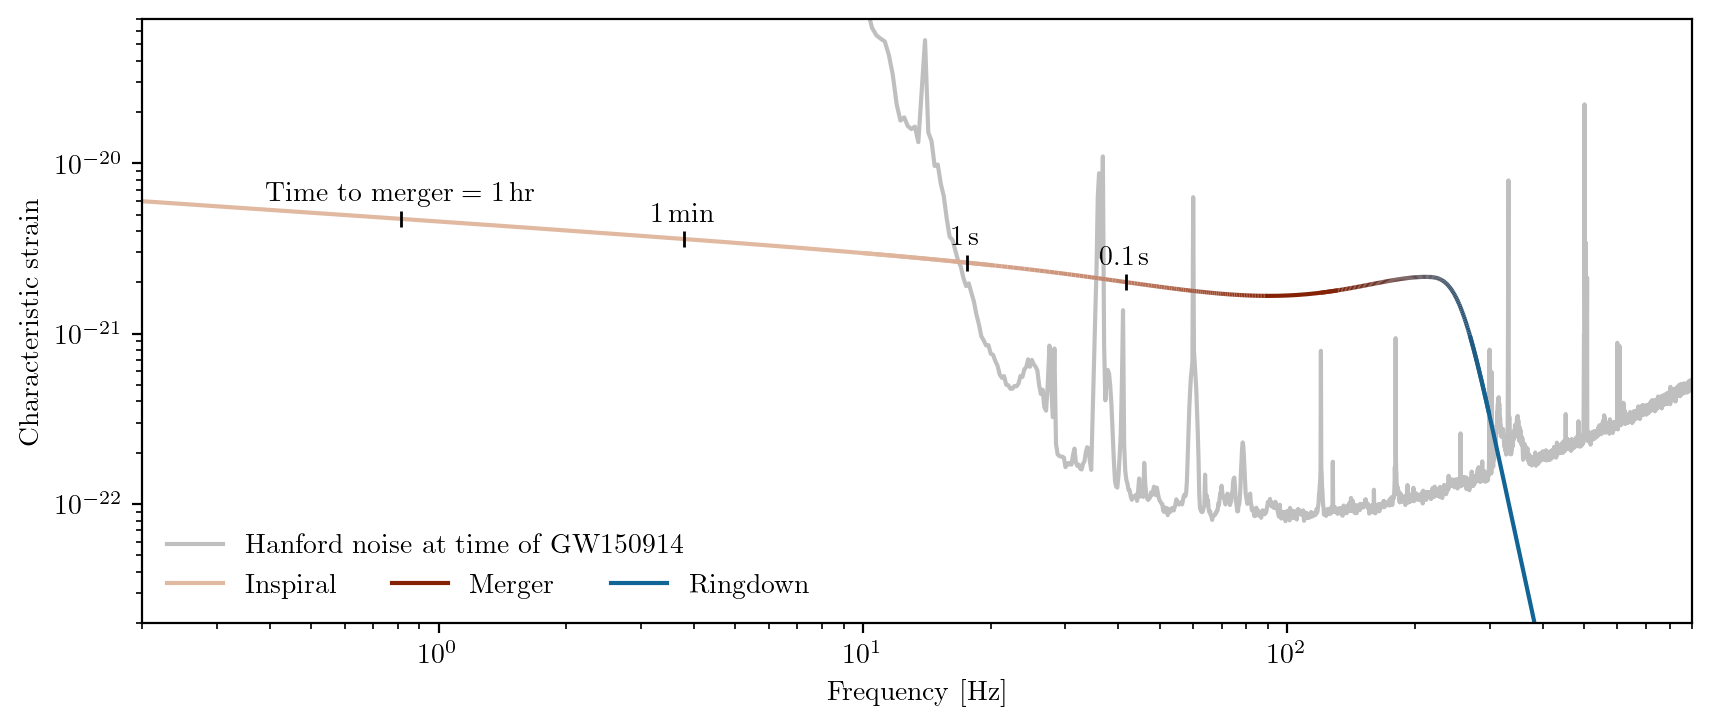

In [12]:
fig, ax = plt.subplots(figsize=(10,4), dpi=200)

asd_f_plot = asd_f[20:]
asd_plot = np.sqrt(asd_f[20:])*asd_dict['H1'](asd_f)[20:]

ax.plot(asd_f_plot, asd_plot, c='k', alpha=0.25)
# ax.plot(psd_f, np.sqrt(psd_f*psd_H))
# ax.plot(psd_f_alt[5:], np.sqrt(psd_f_alt[5:])*psd_H_alt[5:], alpha=0.5)

# IMR colours
cmap = cm.vik
inspiral_colour = cmap(0.6)[:-1]
merger_colour = cmap(0.9)[:-1]
ringdown_colour = cmap(0.2)[:-1]

# The solid colour regions
ax.plot(fs[inspiral_mask], inspiral, c=inspiral_colour)
ax.plot(fs[merger_mask], merger, c=merger_colour)
ax.plot(fs[ringdown_mask], ringdown, c=ringdown_colour)

# Colour maps
# ===========

# Create colour maps from list
i_m_colours = [inspiral_colour, merger_colour]
i_m_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", i_m_colours)

m_r_colours = [merger_colour, ringdown_colour]
m_r_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", m_r_colours)

# Line segments
# =============

# Create a set of line segments so that we can color them individually
i_m_points = np.array([i_m_freqs[::70], inspiral_merger[::70]]).T.reshape(-1, 1, 2)
i_m_segments = np.concatenate([i_m_points[:-1], i_m_points[1:]], axis=1)

m_r_points = np.array([m_r_freqs[::100], merger_ringdown[::100]]).T.reshape(-1, 1, 2)
m_r_segments = np.concatenate([m_r_points[:-1], m_r_points[1:]], axis=1)

# Create a continuous norm to map from data points to colours
i_m_norm = plt.Normalize(i_m_freqs[0], i_m_freqs[-1])
i_m_lc = LineCollection(i_m_segments, cmap=i_m_cmap, norm=i_m_norm)

m_r_norm = plt.Normalize(m_r_freqs[0], m_r_freqs[-1])
m_r_lc = LineCollection(m_r_segments, cmap=m_r_cmap, norm=m_r_norm)

# Set the values used for colormapping
i_m_lc.set_array(i_m_freqs[::70])
m_r_lc.set_array(m_r_freqs[::100])

# Add lines to the figure
i_m_line = ax.add_collection(i_m_lc)
m_r_line = ax.add_collection(m_r_lc)

custom_lines = [Line2D([0], [0], color=c) for c in [inspiral_colour, merger_colour, ringdown_colour]]
l1 = ax.legend(
    custom_lines, 
    ['Inspiral', 'Merger', 'Ringdown'], 
    frameon=False, 
    ncol=3, 
    loc='lower left', 
    # bbox_to_anchor=(0.49,-0.12)
    )

ax.add_artist(l1)

ax.legend(
    [Line2D([0], [0], c='k', alpha=0.25)],
    ['Hanford noise at time of GW150914'],
    frameon=False, 
    loc='lower left',
    bbox_to_anchor=(0.,0.065)
    )

for m in markers:
    ax.plot(m[0],m[1], '|', c='k')

xlim = [0.2, 900]
ylim = [2e-23, 7e-20]

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.text(
    (np.log10(markers[0][0])-np.log10(xlim[0]))/(np.log10(xlim[1])-np.log10(xlim[0])), 
    (np.log10(markers[0][1])-np.log10(ylim[0]))/(np.log10(ylim[1])-np.log10(ylim[0]))+0.03,  
    '$\mathrm{Time\ to\ merger} = 1\,\mathrm{hr}$', 
    horizontalalignment='center',
    transform=ax.transAxes
    )   

ax.text(
    (np.log10(markers[1][0])-np.log10(xlim[0]))/(np.log10(xlim[1])-np.log10(xlim[0])), 
    (np.log10(markers[1][1])-np.log10(ylim[0]))/(np.log10(ylim[1])-np.log10(ylim[0]))+0.03,  
    '$1\,\mathrm{min}$', 
    horizontalalignment='center',
    transform=ax.transAxes
    )  

ax.text(
    (np.log10(markers[2][0])-np.log10(xlim[0]))/(np.log10(xlim[1])-np.log10(xlim[0])), 
    (np.log10(markers[2][1])-np.log10(ylim[0]))/(np.log10(ylim[1])-np.log10(ylim[0]))+0.03,  
    '$1\,\mathrm{s}$', 
    horizontalalignment='center',
    transform=ax.transAxes
    )   

ax.text(
    (np.log10(markers[3][0])-np.log10(xlim[0]))/(np.log10(xlim[1])-np.log10(xlim[0])), 
    (np.log10(markers[3][1])-np.log10(ylim[0]))/(np.log10(ylim[1])-np.log10(ylim[0]))+0.03,  
    '$0.1\,\mathrm{s}$', 
    horizontalalignment='center',
    transform=ax.transAxes
    )   
    
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylabel('Characteristic strain')
ax.set_xlabel('Frequency [Hz]')

fig.savefig('fd_waveform.pdf', bbox_inches='tight')

Assuming equal SNR across H and L, in each detector we have an SNR

In [13]:
np.sqrt(26**2/2)

18.384776310850235

In [14]:
# Integrating by eye...
2e-21/1e-22

19.999999999999996

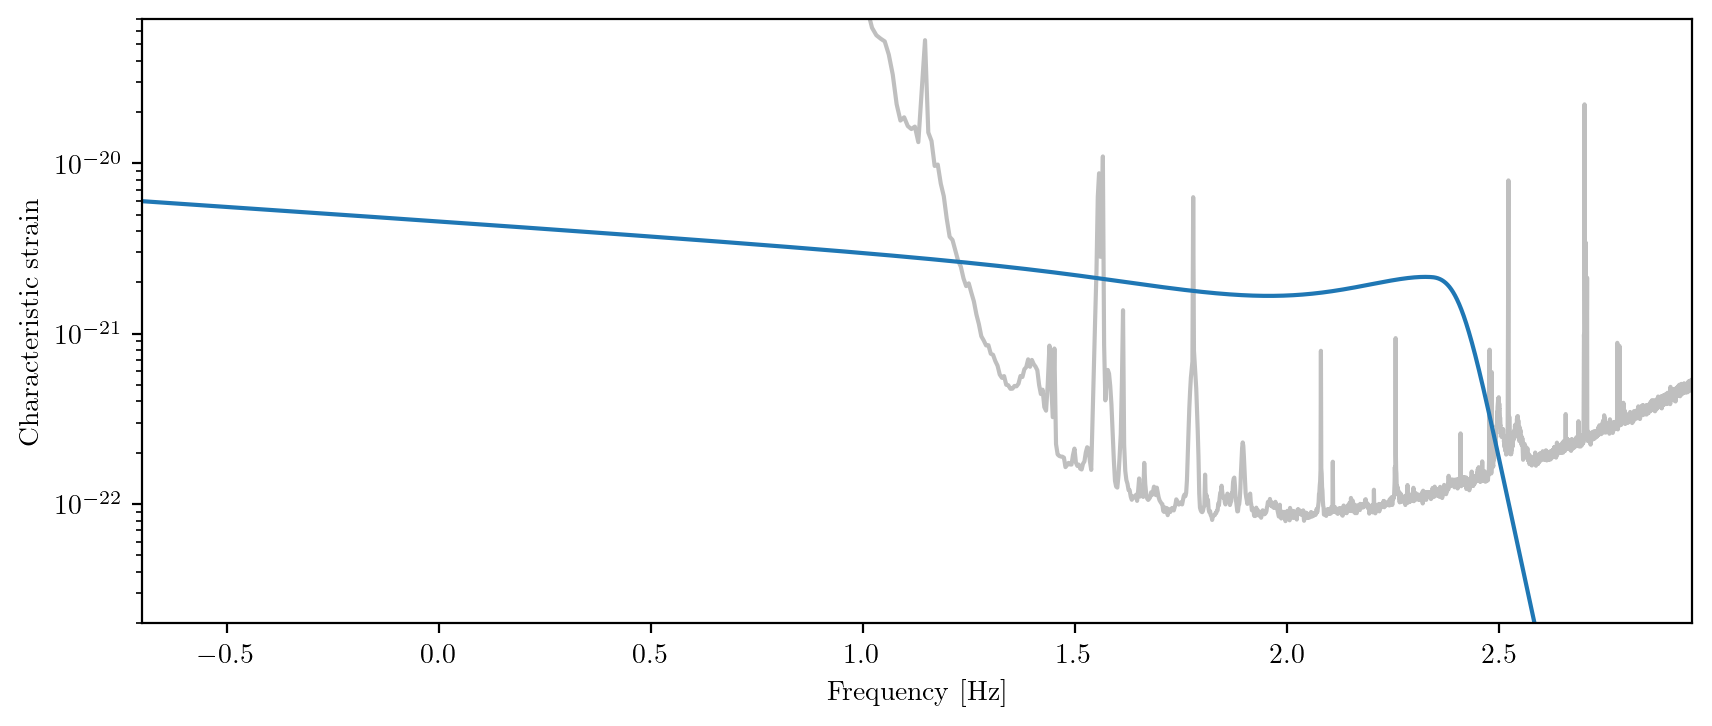

In [15]:
# Integrating properly:

fig, ax = plt.subplots(figsize=(10,4), dpi=200)

ax.plot(np.log10(asd_f_plot), asd_plot, c='k', alpha=0.25)
ax.plot(np.log10(fs), h_plot)

xlim = [np.log10(0.2), np.log10(900)]
ylim = [2e-23, 7e-20]

ax.set_xlim(xlim)
ax.set_ylim(ylim) 

ax.set_yscale('log')

ax.set_ylabel('Characteristic strain')
_ = ax.set_xlabel('Frequency [Hz]')

In [16]:
f_interp = np.linspace(0.5, 3, 1000)

In [17]:
hc = np.interp(f_interp, np.log10(fs), h_plot)
hn = np.interp(f_interp, np.log10(asd_f_plot), asd_plot)

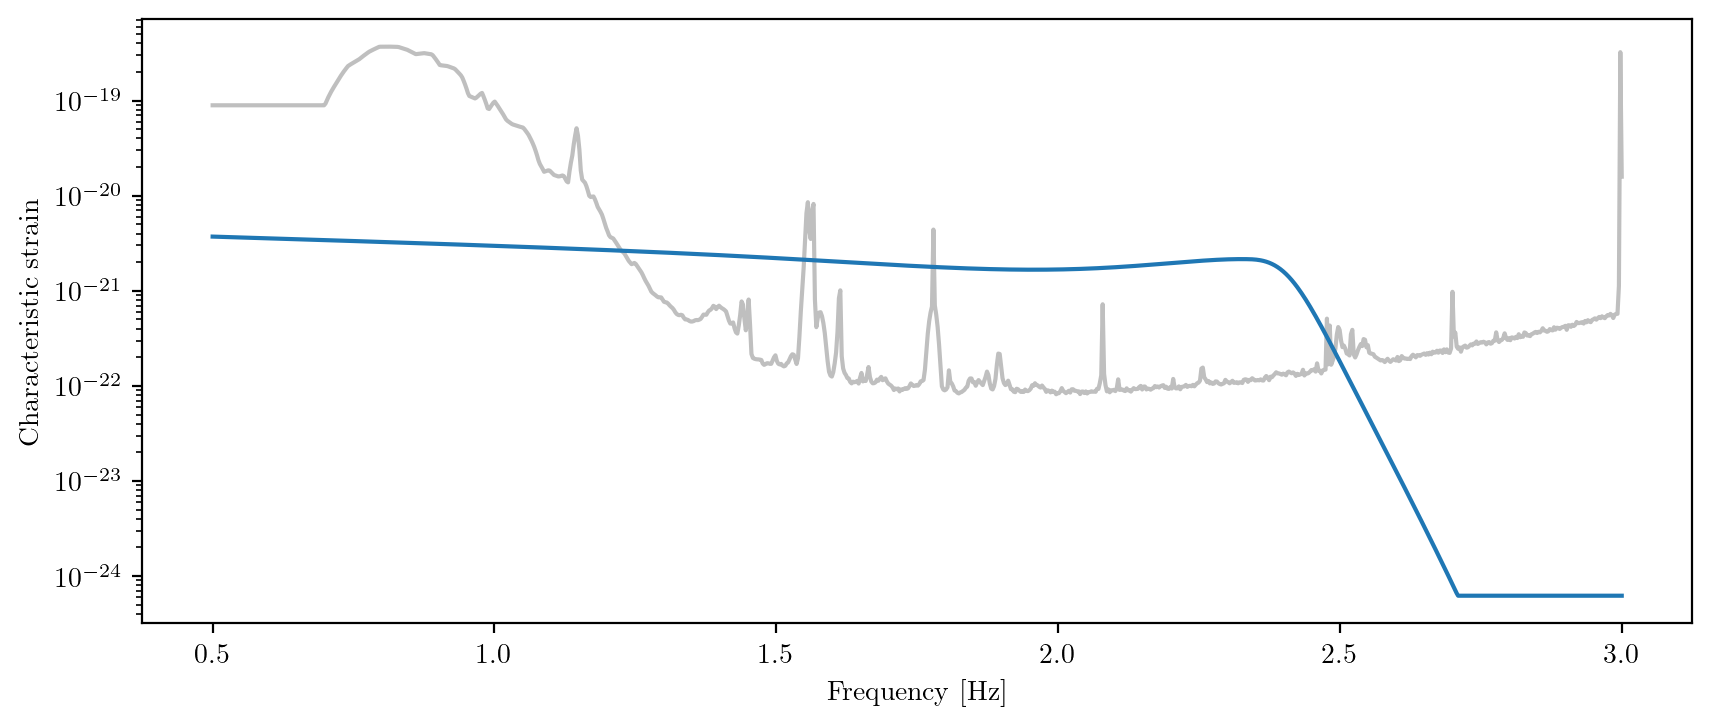

In [18]:
fig, ax = plt.subplots(figsize=(10,4), dpi=200)

ax.plot(f_interp, hn, c='k', alpha=0.25)
ax.plot(f_interp, hc)


xlim = [np.log10(0.2), np.log10(900)]
ylim = [2e-23, 7e-20]

# ax.set_xlim(xlim)
# ax.set_ylim(ylim) 

ax.set_yscale('log')

ax.set_ylabel('Characteristic strain')
_ = ax.set_xlabel('Frequency [Hz]')

In [19]:
np.sqrt(np.trapz((hc/hn)**2, x=f_interp))

16.5544259452033

In [21]:
f_formation = gw_frequency_from_a(0.2*au, M_sun*(m1 + m2))

# Time to merger in Gyr
time_to_merger(f_formation, float(Mc)*M_sun)/(1e9*365*24*60*60)

5.50560142641493